In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df= pd.read_csv("drive/MyDrive/pca_reduced_dataset.csv")

In [2]:
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nClass distribution:")
print(df['Churn'].value_counts())
print("\nPercentage distribution:")
print(df['Churn'].value_counts(normalize=True) * 100)

Dataset shape: (7043, 15)

First 5 rows:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.826706 -1.373583 -1.230767 -0.087034  1.283266 -0.712259  0.129103   
1 -0.201515 -0.126850 -1.014370 -0.258006 -0.705918  0.652936 -0.216050   
2 -0.456477 -1.324500 -0.911066 -0.079200 -0.499640  0.499167 -0.566206   
3 -0.176442  0.380674 -1.888965 -0.769751 -0.064559  0.539682  0.187003   
4  0.014410 -1.833934  0.274640 -0.250129  0.332321 -0.552265 -0.254106   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  Churn  
0 -0.044028  0.123456  0.226739  0.257677  0.671813  0.579817  0.011222      0  
1  0.606991 -0.826557  0.098576 -0.548355 -0.388974 -0.362146  0.618746      0  
2 -0.012590  0.036379  0.973500  0.384069  0.314796 -0.042328  0.070555      1  
3  0.527100 -0.594101 -0.337365 -0.252536 -0.640810  0.017788  0.420809      0  
4 -0.130753  0.006342 -0.006539  0.255177 -0.173405 -0.516260  0.146374      1  

Dataset info:
<class 

In [3]:
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (5634, 14)
Test set size: (1409, 14)


In [4]:
logreg = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)

logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [5]:
# Make predictions
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]


Confusion Matrix:
[[747 288]
 [ 83 291]]


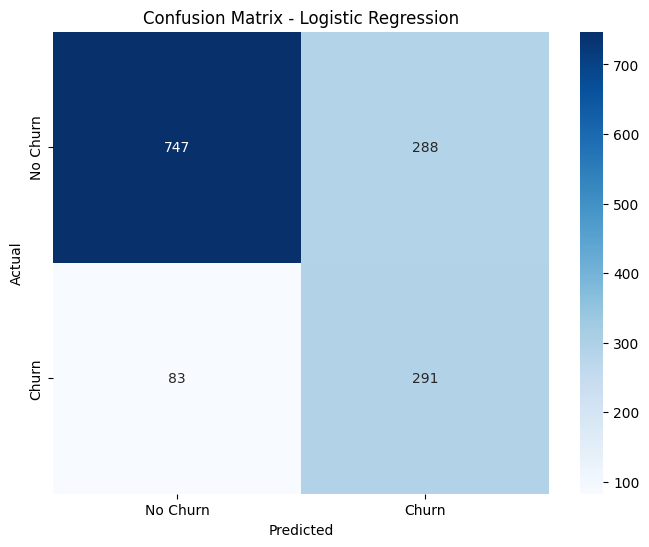

In [7]:
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [8]:
# Cross-validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(logreg, X, y, cv=5, scoring='accuracy')
print(f"\nCross-Validation Results")
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")




Cross-Validation Results
Cross-validation scores: [0.75159688 0.74875798 0.74024131 0.75710227 0.75284091]
Mean CV accuracy: 0.7501 (+/- 0.0112)


In [10]:
accuracy_basic = accuracy_score(y_test, y_pred)
precision_basic = precision_score(y_test, y_pred)
recall_basic = recall_score(y_test, y_pred)
f1_basic = f1_score(y_test, y_pred)
auc_basic = roc_auc_score(y_test, y_pred_proba)

print(f"\nPerformance Metrics:")
print(f"Accuracy: {accuracy_basic:.4f}")
print(f"Precision: {precision_basic:.4f}")
print(f"Recall: {recall_basic:.4f}")
print(f"F1-Score: {f1_basic:.4f}")
print(f"AUC-ROC: {auc_basic:.4f}")


Performance Metrics:
Accuracy: 0.7367
Precision: 0.5026
Recall: 0.7781
F1-Score: 0.6107
AUC-ROC: 0.8375


Variety 2 - GridSearchCV

In [11]:
# Define parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

# GridSearchCV with 5-fold cross-validation
lr_tuned = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=2000),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Performing hyperparameter tuning with GridSearchCV...")
lr_tuned.fit(X_train, y_train)

print(f"\nBest Parameters: {lr_tuned.best_params_}")
print(f"Best Cross-validation Score: {lr_tuned.best_score_:.4f}")



Performing hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-validation Score: 0.6286


In [12]:
# Get the best estimator
best_lr = lr_tuned.best_estimator_

# Make predictions with tuned model
y_pred_tuned = best_lr.predict(X_test)
y_pred_proba_tuned = best_lr.predict_proba(X_test)[:, 1]

# Evaluate tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print(f"\nPerformance Metrics (Tuned):")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1-Score: {f1_tuned:.4f}")
print(f"AUC-ROC: {auc_tuned:.4f}")



Performance Metrics (Tuned):
Accuracy: 0.7367
Precision: 0.5026
Recall: 0.7781
F1-Score: 0.6107
AUC-ROC: 0.8375



Confusion Matrix (Tuned Model):
[[747 288]
 [ 83 291]]


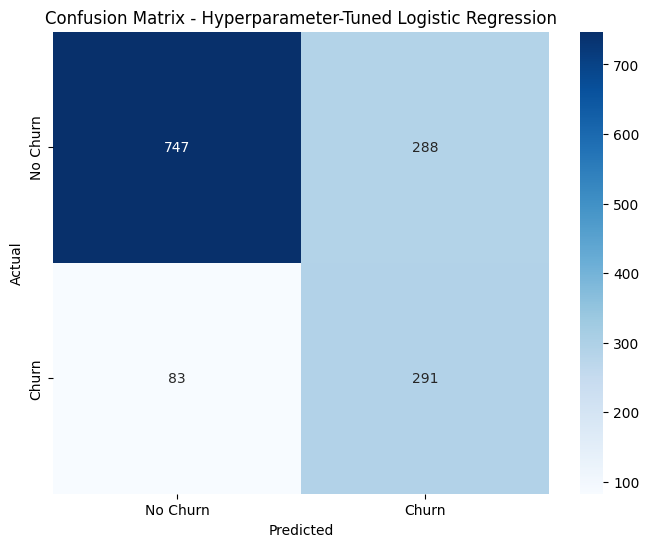

In [13]:
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
print(f"\nConfusion Matrix (Tuned Model):")
print(cm_tuned)

# Plot confusion matrix for tuned model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Hyperparameter-Tuned Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [14]:
# Cross-validation for tuned model
cv_scores_tuned = cross_val_score(best_lr, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_scores_tuned.mean():.4f} (+/- {cv_scores_tuned.std() * 2:.4f})")

# Coefficient analysis for tuned model
if hasattr(best_lr, 'coef_'):
    coef_tuned = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': best_lr.coef_[0],
        'Abs_Coefficient': np.abs(best_lr.coef_[0])
    }).sort_values('Abs_Coefficient', ascending=False)

    print(f"\nTop 5 Features (Tuned Model):")
    print(coef_tuned.head(5))

Cross-validation Accuracy: 0.7504 (+/- 0.0115)

Top 5 Features (Tuned Model):
   Feature  Coefficient  Abs_Coefficient
1      PC2    -1.321836         1.321836
2      PC3     0.595432         0.595432
4      PC5     0.428838         0.428838
10    PC11    -0.413943         0.413943
0      PC1     0.315598         0.315598


Variety 3 - Scaled data with different solver

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression with different solver and scaled data
lr_scaled = LogisticRegression(
    random_state=42,
    max_iter=1000,
    C=1.0,  # Moderate regularization
    penalty='l2',
    solver='lbfgs',  # Different solver that works well with scaled data
    class_weight='balanced'
)

# Train on scaled data
lr_scaled.fit(X_train_scaled, y_train)

# Make predictions
y_pred_scaled = lr_scaled.predict(X_test_scaled)
y_pred_proba_scaled = lr_scaled.predict_proba(X_test_scaled)[:, 1]


In [16]:
# Evaluate scaled model
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)
precision_scaled = precision_score(y_test, y_pred_scaled)
recall_scaled = recall_score(y_test, y_pred_scaled)
f1_scaled = f1_score(y_test, y_pred_scaled)
auc_scaled = roc_auc_score(y_test, y_pred_proba_scaled)

print(f"\nPerformance Metrics (Scaled Data):")
print(f"Accuracy: {accuracy_scaled:.4f}")
print(f"Precision: {precision_scaled:.4f}")
print(f"Recall: {recall_scaled:.4f}")
print(f"F1-Score: {f1_scaled:.4f}")
print(f"AUC-ROC: {auc_scaled:.4f}")


Performance Metrics (Scaled Data):
Accuracy: 0.7367
Precision: 0.5026
Recall: 0.7781
F1-Score: 0.6107
AUC-ROC: 0.8375



Confusion Matrix (Scaled Data Model):
[[747 288]
 [ 83 291]]


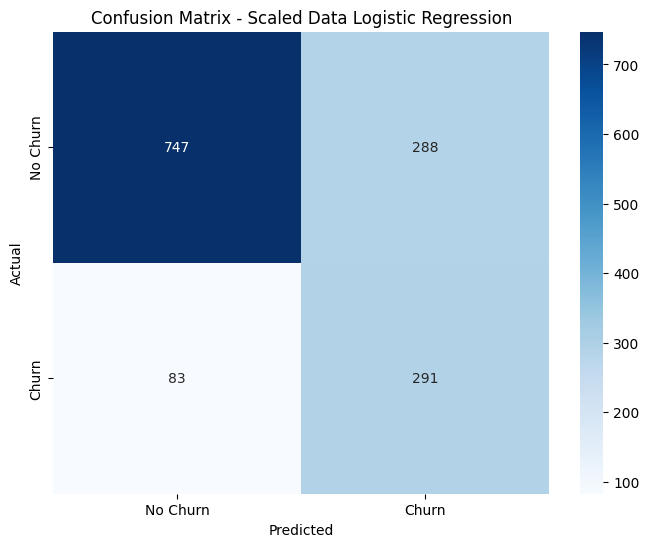

In [17]:
cm_scaled = confusion_matrix(y_test, y_pred_scaled)
print(f"\nConfusion Matrix (Scaled Data Model):")
print(cm_scaled)

# Plot confusion matrix for scaled model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_scaled, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Scaled Data Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [18]:
# Cross-validation
X_scaled = scaler.fit_transform(X)
cv_scores_scaled = cross_val_score(lr_scaled, X_scaled, y, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_scores_scaled.mean():.4f} (+/- {cv_scores_scaled.std() * 2:.4f})")

# Coefficient analysis for scaled model
if hasattr(lr_scaled, 'coef_'):
    coef_scaled = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': lr_scaled.coef_[0],
        'Abs_Coefficient': np.abs(lr_scaled.coef_[0])
    }).sort_values('Abs_Coefficient', ascending=False)

    print(f"\nTop 5 Features (Scaled Model):")
    print(coef_scaled.head(5))

Cross-validation Accuracy: 0.7504 (+/- 0.0115)

Top 5 Features (Scaled Model):
   Feature  Coefficient  Abs_Coefficient
1      PC2    -1.478174         1.478174
0      PC1     0.505682         0.505682
2      PC3     0.420899         0.420899
4      PC5     0.224151         0.224151
10    PC11    -0.162607         0.162607


In [19]:
comparison_data = {
    'Model': ['Basic Logistic Regression', 'Hyperparameter-Tuned', 'Scaled Data with Different Solver'],
    'Accuracy': [accuracy_basic, accuracy_tuned, accuracy_scaled],
    'Precision': [precision_basic, precision_tuned, precision_scaled],
    'Recall': [recall_basic, recall_tuned, recall_scaled],
    'F1-Score': [f1_basic, f1_tuned, f1_scaled],
    'AUC-ROC': [auc_basic, auc_tuned, auc_scaled],
    'CV_Accuracy': [cv_scores.mean(), cv_scores_tuned.mean(), cv_scores_scaled.mean()],
    'CV_Std': [cv_scores.std(), cv_scores_tuned.std(), cv_scores_scaled.std()]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nPerformance Comparison Across All Varieties:")
print(comparison_df.round(4))

# Find best model based on F1-Score
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
best_f1 = comparison_df.loc[best_model_idx, 'F1-Score']

print(f"\nBest Model: {best_model} (F1-Score: {best_f1:.4f})")


Performance Comparison Across All Varieties:
                               Model  Accuracy  Precision  Recall  F1-Score  \
0          Basic Logistic Regression    0.7367     0.5026  0.7781    0.6107   
1               Hyperparameter-Tuned    0.7367     0.5026  0.7781    0.6107   
2  Scaled Data with Different Solver    0.7367     0.5026  0.7781    0.6107   

   AUC-ROC  CV_Accuracy  CV_Std  
0   0.8375       0.7501  0.0056  
1   0.8375       0.7504  0.0058  
2   0.8375       0.7504  0.0058  

Best Model: Basic Logistic Regression (F1-Score: 0.6107)


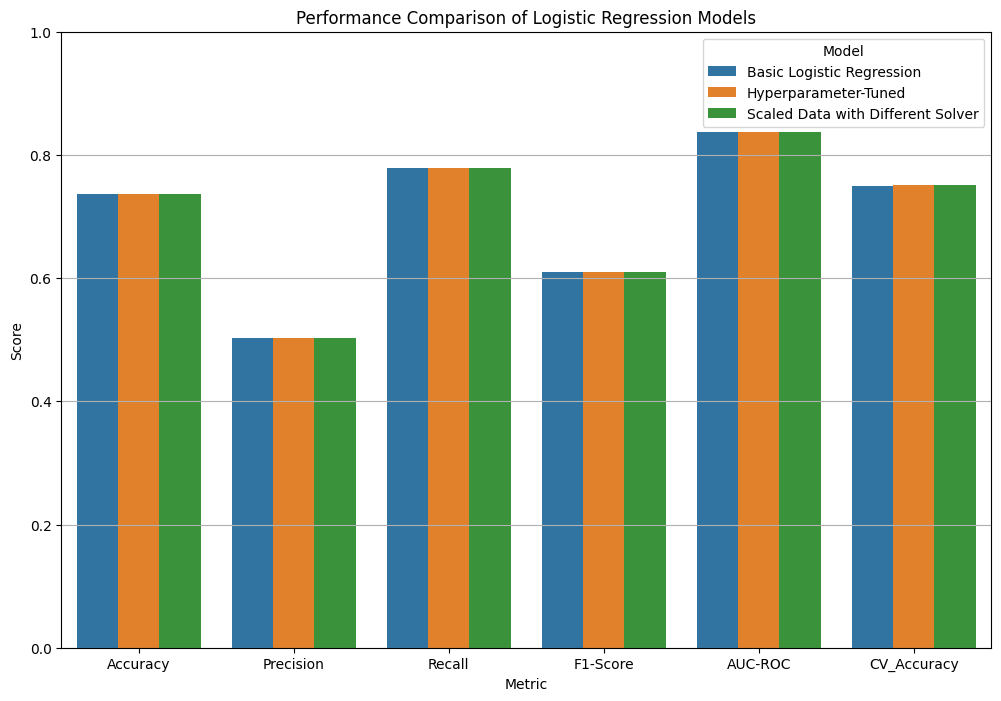

In [20]:
comparison_melted = comparison_df.melt(
    'Model',
    var_name='Metric',
    value_name='Score',
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'CV_Accuracy']
)

plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_melted)
plt.title('Performance Comparison of Logistic Regression Models')
plt.ylabel('Score')
plt.ylim(0, 1) # Metrics are typically between 0 and 1
plt.grid(axis='y')
plt.show()